# End-to-end DSPy Workflows Guide 

# TODO: Motivation - have this problem and going to solve it with dspy and that is why we believe ti is the right solution

This guide will cover the following topics:

## Creating a Multi-stage LLM Pipeline
- Building a pipeline with an untuned model in DSPy
- Implementing batch inference (using Ray data)

## Improving the Pipeline
1. Prompt optimization
2. Fine-tuning
    - How to make an 8B model perform almost as well as a 70B model in your pipeline
3. Combining fine-tuning with prompt optimization

## Deployment
- Steps to deploy the optimized pipeline and fine-tuned model to production

## Future Work and Open Questions
- Efficient batch inference with a DSPy pipeline
- Exploring different fine-tuning methods and hyperparameter sweeps

This guide aims to provide a comprehensive overview of building, optimizing, and deploying LLM pipelines using DSPy and Anyscale.

## Set up

Node Set up:

We will be running everything on a head node that uses 4xA100-80GB GPUs. I find that L4s are usually available and suitable for this usecase. You can also use any more powerful node.

To change to use A100 GPUs, click the "1 active node" in the top right corner, then for workspace node, click the pencil icon and navigate to the A100 tab and select the 4xA100 option. If you do not see A100 in the list of GPUs, they may not be available on your cloud. Choose another kind of GPU (This notebook has been tested on X, and Y as alternatives) (TODO)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# TODO(work): DSPy installation cell
# TODO(decision): are these changes going to be merged into DSPy main

# TODO: look at my own init file to see all the stupid extra pip installs

# !pip install -e dspy-d
# !pip install -r dspy-d/requirements.txt
# !pip install vllm

# ignore future warnings
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [3]:
import dspy
import dsp
import os
import ujson

from dotenv import load_dotenv
# TODO: include cache in notebook
cache_dir = "/home/ray/default/dspy/cache"
if not os.path.exists(cache_dir):
    os.makedirs(cache_dir)
# I have included a .env.example with the necessary environment variables to be set
# You can also set them manually if you prefer

os.environ["DSP_CACHEDIR"] = cache_dir

load_dotenv()

dspy.settings.configure(experimental=True)

In [4]:
import litellm

litellm.set_verbose=False
litellm.suppress_debug_info=True

In [5]:
necessary_env_vars = [
    "DSP_CACHEDIR",
    "HF_TOKEN",
    "HF_HOME"
]

for var in necessary_env_vars:
    assert os.environ[var], f"{var} is not set"

In [6]:
import ray

if not ray.is_initialized():
    ray.init(runtime_env={"env_vars": os.environ, "py_modules": [dspy, dsp]})

2024-10-09 22:01:23,415	INFO worker.py:1601 -- Connecting to existing Ray cluster at address: 10.0.15.194:6379...
2024-10-09 22:01:23,424	INFO worker.py:1777 -- Connected to Ray cluster. View the dashboard at https://session-fkvdirx4bzefi53sjl55m7asad.i.anyscaleuserdata.com 
2024-10-09 22:01:23,450	INFO packaging.py:531 -- Creating a file package for local directory '/home/ray/default/dspy/dspy'.
2024-10-09 22:01:23,482	INFO packaging.py:359 -- Pushing file package 'gcs://_ray_pkg_16a6ced495b26a30.zip' (0.89MiB) to Ray cluster...
2024-10-09 22:01:23,493	INFO packaging.py:372 -- Successfully pushed file package 'gcs://_ray_pkg_16a6ced495b26a30.zip'.
2024-10-09 22:01:23,506	INFO packaging.py:531 -- Creating a file package for local directory '/home/ray/default/dspy/dsp'.
2024-10-09 22:01:23,527	INFO packaging.py:359 -- Pushing file package 'gcs://_ray_pkg_71ca589731f467e9.zip' (0.64MiB) to Ray cluster...
2024-10-09 22:01:23,530	INFO packaging.py:372 -- Successfully pushed file package 'g

(autoscaler +1m11s) Tip: use `ray status` to view detailed cluster status. To disable these messages, set RAY_SCHEDULER_EVENTS=0.


We will make use of a random number generator in this notebook. We are creating a Random object here to ensure that our notebook is reproducible.

In [7]:
import random

rng = random.Random(0)

# Creating your multi-stage LLM pipeline

In [8]:
from dspy.datasets import HotPotQA
from dspy.evaluate import Evaluate
from dsp.utils.utils import deduplicate


# We are setting the experimental flag to True to make use of the fine-tuning
# features that are still in development.
dspy.settings.configure(experimental=True)

class IntentClassification(dspy.Signature):
    """As a part of a banking issue traiging system, classify the intent of a natural language query into one of the 25 labels.
    The intent should exactly match one of the following:
    ['activate_my_card', 'balance_not_updated_after_bank_transfer', 'balance_not_updated_after_cheque_or_cash_deposit', 'beneficiary_not_allowed', 'cancel_transfer', 'card_arrival', 'card_payment_fee_charged', 'card_payment_not_recognised', 'card_payment_wrong_exchange_rate', 'cash_withdrawal_charge', 'cash_withdrawal_not_recognised', 'declined_card_payment', 'declined_cash_withdrawal', 'direct_debit_payment_not_recognised', 'extra_charge_on_statement', 'pending_card_payment', 'pending_top_up', 'Refund_not_showing_up', 'request_refund', 'reverted_card_payment', 'transaction_charged_twice', 'transfer_fee_charged', 'transfer_not_received_by_recipient', 'wrong_amount_of_cash_received', 'wrong_exchange_rate_for_cash_withdrawal']
    """

    intent = dspy.InputField(desc="Intent of the query")
    label = dspy.OutputField(desc="Type of the intent; Should just be one of the 25 labels with no other text")

class IntentClassificationModule(dspy.Module):
    def __init__(self):
        self.intent_classifier = dspy.ChainOfThought(IntentClassification)
        self.valid_labels = set(["activate_my_card", "cancel_transfer", "cash_withdrawal_charge", "declined_card_payment", "declined_cash_withdrawal", "direct_debit_payment_not_recognised", "extra_charge_on_statement", "pending_card_payment", "pending_top_up", "Refund_not_showing_up", "request_refund", "reverted_card_payment", "transaction_charged_twice", "transfer_fee_charged", "transfer_not_received_by_recipient", "wrong_amount_of_cash_received", "wrong_exchange_rate_for_cash_withdrawal"])

    def forward(self, text):
        prediction = self.intent_classifier(intent=text)
        sanitized_prediction = dspy.Prediction(label=prediction.label.lower().strip().replace(" ", "_"), reasoning=prediction.reasoning)
        # if sanitized_prediction.label not in self.valid_labels:
        #     for label in self.valid_labels:
        #         if label in sanitized_prediction.label:
        #             sanitized_prediction.label = label
        #             break
        #     # this means that the prediction was not in the valid labels
        #     # Could do edit distance or something more sophisticated here
        #     # but for now just take the first
        #     sanitized_prediction.label = self.valid_labels[0]
        return sanitized_prediction



# Let's break down the Text to SQL program

Below we load the dataset using a built in `HotPotQA` dataset class from DSPy.

We set the `train_seed` and `eval_seed` to `0` for reproducibility and the `test_size` to `0` because we do not need a test set for this tutorial.

In [9]:
# Prepare the dataset
from dspy.datasets import DataLoader

dl = DataLoader()
full_trainset = dl.from_huggingface(
    dataset_name="PolyAI/banking77", # Dataset name from Huggingface
    fields=("label", "text"), # Fields needed
    input_keys=("text",), # What our model expects to recieve to generate an output
    split="train"
)

full_testset = dl.from_huggingface(
    dataset_name="PolyAI/banking77", # Dataset name from Huggingface
    fields=("label", "text"), # Fields needed
    input_keys=("text",), # What our model expects to recieve to generate an output
    split="test"
)

# Find the 15 most common class labels
from collections import Counter

# Count occurrences of each label
label_counts = Counter(example['label'] for example in full_trainset)
print(label_counts)

# Get the 15 most common labels
top_25_labels = set([label for label, _ in label_counts.most_common(25)])

# Filter the datasets to only include examples with the top 15 labels
full_trainset_filtered = [example for example in full_trainset if example['label'] in top_25_labels]
full_testset_filtered = [example for example in full_testset if example['label'] in top_25_labels]

# Replace the original datasets with the filtered versions
full_trainset = full_trainset_filtered
full_testset = full_testset_filtered

print(f"Dataset filtered to top 25 labels. New sizes:")
print(f"Training set: {len(full_trainset)}")
print(f"Test set: {len(full_testset)}")
print(f"Top 25 labels: {', '.join(str(label) for label in top_25_labels)}")

Counter({15: 187, 28: 182, 6: 181, 75: 180, 19: 177, 63: 175, 26: 173, 64: 172, 66: 171, 5: 171, 52: 169, 16: 168, 17: 167, 34: 166, 76: 163, 51: 162, 53: 161, 20: 160, 45: 159, 0: 159, 8: 157, 7: 156, 11: 153, 25: 153, 47: 149, 48: 148, 61: 146, 59: 145, 46: 143, 13: 139, 35: 137, 73: 135, 27: 133, 54: 129, 39: 129, 9: 129, 24: 129, 67: 128, 4: 127, 36: 126, 71: 126, 2: 126, 21: 122, 30: 121, 74: 121, 29: 121, 42: 121, 31: 121, 43: 120, 33: 118, 49: 115, 58: 114, 57: 114, 70: 113, 65: 113, 32: 112, 12: 112, 14: 112, 56: 111, 1: 110, 55: 108, 38: 106, 44: 105, 69: 104, 62: 103, 68: 102, 40: 98, 60: 97, 37: 97, 50: 95, 3: 87, 22: 86, 41: 82, 18: 61, 10: 59, 72: 41, 23: 35})
Dataset filtered to top 25 labels. New sizes:
Training set: 4171
Test set: 1000
Top 25 labels: 0, 5, 6, 7, 8, 11, 15, 16, 17, 19, 20, 25, 26, 28, 34, 45, 47, 51, 52, 53, 63, 64, 66, 75, 76


In [10]:
int_to_label_dict = {
    0: "activate_my_card",
    1: "age_limit",
    2: "apple_pay_or_google_pay",
    3: "atm_support",
    4: "automatic_top_up",
    5: "balance_not_updated_after_bank_transfer",
    6: "balance_not_updated_after_cheque_or_cash_deposit",
    7: "beneficiary_not_allowed",
    8: "cancel_transfer",
    9: "card_about_to_expire",
    10: "card_acceptance",
    11: "card_arrival",
    12: "card_delivery_estimate",
    13: "card_linking",
    14: "card_not_working",
    15: "card_payment_fee_charged",
    16: "card_payment_not_recognised",
    17: "card_payment_wrong_exchange_rate",
    18: "card_swallowed",
    19: "cash_withdrawal_charge",
    20: "cash_withdrawal_not_recognised",
    21: "change_pin",
    22: "compromised_card",
    23: "contactless_not_working",
    24: "country_support",
    25: "declined_card_payment",
    26: "declined_cash_withdrawal",
    27: "declined_transfer",
    28: "direct_debit_payment_not_recognised",
    29: "disposable_card_limits",
    30: "edit_personal_details",
    31: "exchange_charge",
    32: "exchange_rate",
    33: "exchange_via_app",
    34: "extra_charge_on_statement",
    35: "failed_transfer",
    36: "fiat_currency_support",
    37: "get_disposable_virtual_card",
    38: "get_physical_card",
    39: "getting_spare_card",
    40: "getting_virtual_card",
    41: "lost_or_stolen_card",
    42: "lost_or_stolen_phone",
    43: "order_physical_card",
    44: "passcode_forgotten",
    45: "pending_card_payment",
    46: "pending_cash_withdrawal",
    47: "pending_top_up",
    48: "pending_transfer",
    49: "pin_blocked",
    50: "receiving_money",
    51: "Refund_not_showing_up",
    52: "request_refund",
    53: "reverted_card_payment",
    54: "supported_cards_and_currencies",
    55: "terminate_account",
    56: "top_up_by_bank_transfer_charge",
    57: "top_up_by_card_charge",
    58: "top_up_by_cash_or_cheque",
    59: "top_up_failed",
    60: "top_up_limits",
    61: "top_up_reverted",
    62: "topping_up_by_card",
    63: "transaction_charged_twice",
    64: "transfer_fee_charged",
    65: "transfer_into_account",
    66: "transfer_not_received_by_recipient",
    67: "transfer_timing",
    68: "unable_to_verify_identity",
    69: "verify_my_identity",
    70: "verify_source_of_funds",
    71: "verify_top_up",
    72: "virtual_card_not_working",
    73: "visa_or_mastercard",
    74: "why_verify_identity",
    75: "wrong_amount_of_cash_received",
    76: "wrong_exchange_rate_for_cash_withdrawal"
}

label_to_int_dict = {v: k for k, v in int_to_label_dict.items()}

In [11]:
labels_in_use = [int_to_label_dict[label] for label in top_25_labels]

print(labels_in_use)

def convert_int_to_label(example):
    example["label"] = int_to_label_dict[example["label"]]
    return example

full_trainset = [convert_int_to_label(example) for example in full_trainset]
full_testset = [convert_int_to_label(example) for example in full_testset]

print(full_trainset[0])

['activate_my_card', 'balance_not_updated_after_bank_transfer', 'balance_not_updated_after_cheque_or_cash_deposit', 'beneficiary_not_allowed', 'cancel_transfer', 'card_arrival', 'card_payment_fee_charged', 'card_payment_not_recognised', 'card_payment_wrong_exchange_rate', 'cash_withdrawal_charge', 'cash_withdrawal_not_recognised', 'declined_card_payment', 'declined_cash_withdrawal', 'direct_debit_payment_not_recognised', 'extra_charge_on_statement', 'pending_card_payment', 'pending_top_up', 'Refund_not_showing_up', 'request_refund', 'reverted_card_payment', 'transaction_charged_twice', 'transfer_fee_charged', 'transfer_not_received_by_recipient', 'wrong_amount_of_cash_received', 'wrong_exchange_rate_for_cash_withdrawal']
Example({'label': 'card_arrival', 'text': 'I am still waiting on my card?'}) (input_keys={'text'})


In [12]:
DEV_SIZE = 500
PROMPT_OPT_TRAIN_SIZE = 150
PROMPT_OPT_DEV_SIZE = 350

shuffled_trainset = [d for d in full_trainset]
rng.shuffle(shuffled_trainset)

devset = shuffled_trainset[:DEV_SIZE]
remaining_trainset = shuffled_trainset[DEV_SIZE:]

# The devset shouldn't overlap
ft_trainset = remaining_trainset
ft_optimizer_trainset = remaining_trainset[:PROMPT_OPT_TRAIN_SIZE]
ft_optimizer_devset = remaining_trainset[PROMPT_OPT_TRAIN_SIZE:PROMPT_OPT_TRAIN_SIZE+PROMPT_OPT_DEV_SIZE]

po_trainset = remaining_trainset[:-PROMPT_OPT_DEV_SIZE]
po_devset = remaining_trainset[-PROMPT_OPT_DEV_SIZE:]

testset = full_testset

Here we set up the metric and evaluator. We will be using the answer exact match metric.

The evaluator is what we will consider as our test set.

We choose `num_threads=90` because we are bottlenecked by the retrieval server, and through testing this is the maximum number of concurrent threads that can be run without causing issues for other people using the retrieval server.

In [13]:
# Prepare the metric and evaluator
from dspy.evaluate import answer_exact_match

NUM_THREADS = 250

metric = answer_exact_match
common_kwargs = dict(metric=metric, num_threads=NUM_THREADS, display_progress=True, max_errors=10000)

evaluate_devset = Evaluate(devset=devset, **common_kwargs)
evaluate_testset = Evaluate(devset=testset, **common_kwargs)

In [ ]:
def read_jsonl(filename):
    with open(filename, "r") as f:
        return [ujson.loads(line) for line in f]

def write_jsonl(filename, data):
    with open(filename, "w") as f:
        for item in data:
            f.write(ujson.dumps(item) + "\n")

TODO(optional): Implement LLM as judge

## Gathering baseline performance

run evaluate on a base pipeline

In [14]:
MAX_TOKENS = 1000
MODEL_PARAMETERS = {
  "max_tokens": MAX_TOKENS,
  "temperature": 0,
}

LOCAL_API_PARAMETERS = {
  "api_base": "http://localhost:8000/v1",
  "api_key": "fake-key-doesnt-matter"
}
vanilla_program = IntentClassificationModule()

In [15]:
# Note: Run above this to do all setup without launching any models

We will be using a local VLLM instance to run the initial benchmarks and data collection.

In [ ]:
# Command for easy copying: 
# `vllm serve meta-llama/Meta-Llama-3.1-8B-Instruct --port 8000 --pipeline_parallel_size 4 --enable_prefix_caching`
# `vllm serve meta-llama/Llama-3.2-1B-Instruct --port 8000 --pipeline_parallel_size 4 --enable_prefix_caching`
input("Press Enter once you have the vllm server running...")

# Gathering training data and running the 70B Model

Now that we have a baseline for the 8B model, let's run the 70B model and compare its performance.

## Preparation

Before running the 70B model:
1. Kill the 8B server (use `Ctrl+C`) to free up memory.
2. Remember to set your HF_TOKEN and HF_HOME environment variables
3. Use the following command to start the 70B server:

   ```
   vllm serve meta-llama/Meta-Llama-3.1-70B-Instruct --port 8000 --pipeline_parallel_size 2 --enable_prefix_caching --tensor_parallel_size 2
   ```

## Parallelism Configuration

We've chosen pipeline parallelism and tensor parallelism of 2 for the 70B model based on our current setup. Here's the reasoning:

1. Model size: The 70B model has 30 parts of ~5 GB each (based on [HuggingFace documentation](https://huggingface.co/meta-llama/Meta-Llama-3.1-70B-Instruct/tree/main)).
   - Total size: 30 * 5 GB = 150 GB

2. Available VRAM:
   - Our GPUs: 80 GB VRAM x 4 = 320 GB
   - Tensor parallelism: floor(320/150) = 2
   - Pipeline parallelism: floor(num_gpus/2) = 2
   - To use all 4 GPUs efficiently:
     - Pipeline parallel size: 2
     - Tensor parallelism: 2

3. Alternative setup (8x24GB GPUs):
   - Pipeline parallel size: 1
   - Tensor parallelism: ceil(150/24) = 7

This configuration allows us to run the 70B model efficiently across our available GPU resources.

Note that I needed to add the HF_HOME var to my serve config

In [ ]:
# Command for easy copying: 
# `export HF_HOME=/mnt/local_storage/huggingface`
# `vllm serve meta-llama/Meta-Llama-3.1-70B-Instruct --port 8000 --pipeline_parallel_size 2 --enable_prefix_caching --tensor_parallel_size 2`

# input("Press Enter once you have the vllm server running...")

In [ ]:
llama_70b = dspy.LM(model="openai/meta-llama/Meta-Llama-3.1-70B-Instruct", **MODEL_PARAMETERS, **LOCAL_API_PARAMETERS)

In [ ]:
# sanity check
with dspy.context(lm=llama_70b):
    test_predictor = IntentClassificationModule()
    sample_input = devset[0]
    print(sample_input)
    print(test_predictor(**sample_input.inputs()).label)

In [ ]:
# Lets see how the vanilla program performs on our small labeled dataset
# vanilla_program = IntentClassificationModule()
# with dspy.context(lm=llama_70b):
#     print("Evaluating the vanilla program on the devset using llama 70B...")
#     true_labeled_eval = evaluate_devset(vanilla_program)

In [ ]:
# We have added this flag to save you some compute and time while running the notebook
COMPILE_PROGRAM = False
EVAL_PROGRAM = False

# Compile the optimizer and evaluate
with dspy.context(lm=llama_70b):
    vanilla_program = IntentClassificationModule()
    if COMPILE_PROGRAM:
        bfrs_base_program = bfrs_optimizer.compile(vanilla_program, trainset=optimizer_trainset, valset=optimizer_valset)
        bfrs_base_program.save(f"b25_70b_31_bfrs_{MAX_BOOTSTRAPPED_DEMOS}_{MAX_LABELED_DEMOS}_{NUM_CANDIDATE_PROGRAMS}.json")
    else:
        bfrs_base_program = IntentClassificationModule()
        bfrs_base_program.load(f"b25_70b_31_bfrs_{MAX_BOOTSTRAPPED_DEMOS}_{MAX_LABELED_DEMOS}_{NUM_CANDIDATE_PROGRAMS}.json")
    if EVAL_PROGRAM:
        llama_70b_bfrs_eval = evaluate_devset(bfrs_base_program)


In [ ]:
from dspy.teleprompt.finetune_teleprompter import bootstrap_data, convert_to_module_level_prompt_completion_data, bootstrap_data_for_round
import ujson

# This should be moved inside the finetune_teleprompter class
def write_data(program, data, filename):
    print("Bootstrapping and writing data to", filename)
    correct_data = bootstrap_data(program, data, metric=metric, num_threads=NUM_THREADS, max_errors=10000)
    correct_data_round = [x for x in correct_data if x["score"]]

    # Convert the data to prompt completion format
    dataset = convert_to_module_level_prompt_completion_data(correct_data_round, program=program, exclude_demos=True)
    
    # Format the data for finetuning using the LM
    print("Writing dataset with length", len(dataset), "to", filename)
    with open(filename, "w") as f:
        ujson.dump(dataset, f)

dataset_filenames = {f"ft_pure_trainset_data_{TRAIN_SIZE}.json": ft_pure_trainset, f"ft_pure_valset_data_{DEV_SIZE}.json": ft_pure_devset, f"ft_mixed_trainset_data_{TRAIN_SIZE}.json": ft_mixed_trainset, f"ft_mixed_valset_data_{DEV_SIZE}.json": ft_mixed_devset}

dspy.settings.configure(experimental=True, lm=llama_70b)

WRITE_DATA = True
if WRITE_DATA:
    for filename, data in dataset_filenames.items():
        bootstrap_program = IntentClassificationModule()
        write_data(bootstrap_program, data, filename)

In [ ]:
# Let's look at an example prompt completion pair!
# with open(f"trainset_data_banking_{TRAIN_SIZE}.json", "r") as f:
#     data_example = ujson.load(f)
from pprint import pprint
data_example = read_jsonl(f"trainset_data_banking_{TRAIN_SIZE}.jsonl")[0]

print("Example prompt:")
pprint(data_example["messages"][:-1])
print("<end prompt>\n"+"-"*50)
print("Example completion:")
pprint(data_example["messages"][-1])
print("<end completion>\n"+"-"*50)

# Fine-tuning

We will use LLM Forge to fine-tune the 8B model.

In order to do this, we need to format our data into the correct format (Follows OpenAI messaging format placed in a jsonl file).

We initially saved the data into a json file in prompt-completion format.

In order to prepare for finetuning, we need to do three steps:
1. Format the data into the correct format and verify that the data is valid
2. Upload the data to GCP
3. Generate the compute configuration file

After the compute configuration file is generated, we can submit the job to LLM Forge, using either the command line or using the anyscale jobs sdk.
TODO: Add the anyscale jobs sdk submit method

In [ ]:
from dsp.modules.lm import TrainingMethod

train_path = f"trainset_data_banking_{TRAIN_SIZE}.jsonl"
eval_path = f"trainset_val_data_banking_{DEV_SIZE}.jsonl"
method = TrainingMethod.SFT

kwargs = {
    "hyperparameters": {
        "num_devices": 4,
        "trainer_resources": None,
        "worker_resources": None,
        "generation_config": {
            "prompt_format": {
                "system": "<|start_header_id|>system<|end_header_id|>\n\n{instruction}<|eot_id|>",
                "user": "<|start_header_id|>user<|end_header_id|>\n{instruction}<|eot_id|>",
                "assistant": "<|start_header_id|>assistant<|end_header_id|>\n\n{instruction}<|eot_id|>",
                "trailing_assistant": "<|start_header_id|>assistant<|end_header_id|>\n\n", # inference-only
                "bos": "<|begin_of_text|>",
                "system_in_user": False,
                "default_system_message": ""
            },
        },
        "learning_rate": 4.5e-5,
        "num_epochs": 6,
        "train_batch_size_per_device": 32
    },
    "use_lora": True,
    # I think this needs to be set dynamically
    # "lora_dynamic_folder": "dspy/lora_weights/prodjob_qmulcjw4x8z599m8hkyja8tbmi/meta-llama/Llama-3.2-1B-Instruct"
}

SKIP_FT = False
if not SKIP_FT:
    # TODO: Get job working with LLMForge
    student_llama_1b = dspy.TrainableAnyscale(model="meta-llama/Llama-3.2-1B-Instruct")
    student_llama_1b.get_finetune(method, train_path, eval_path, **kwargs)

The first model to run is the 8B model in order to collect a baseline of performance.

You can run the local VLLM instance with the following command:

Make sure to set your HF_TOKEN and HF_HOME environment variables

For Anyscale, putting models into /mnt/local_storage is a typical pattern.


`vllm serve meta-llama/Meta-Llama-3.1-8B-Instruct --port 8000 --pipeline_parallel_size 4 --enable_prefix_caching`

Lets break down what this command does:
- `vllm serve` is the command to run the VLLM server
- `meta-llama/Meta-Llama-3.1-8B-Instruct` is the model to run
- `--port 8000` is the port to run the server on
- `--pipeline_parallel_size 4` is the number of pipeline parallel size to run the server with. We are using 4 because we have 4 GPUs all of which can hold an instance of the model.
- `--enable_prefix_caching` is the flag to enable the prefix caching. This will store and reuse the beginnings of prompts to avoid repeating the same computation. This is especially useful for DSPy since we are almost always using prompts with the same beginning parts in the form of few shot demonstrations.

In [ ]:
# Now I need to eval the model with all the possible configurations
# 70B CoT: Have from above
# 1B CoT:
# 1B CoT + BSRS:        
# 1B CoT + BSFT(need to find best epoch):        
# 1B CoT + BSFT + BSRS: 

### Moving things above this

Below is the 70B synthetic data collection code

We hope to bring the 8B performance up to at least 70B level

# Optimizing the LLaMa 70B pipeline

Now we are ready to optimize the pipeline. We want to optimize the 70B pipeline in order to get the best possible data to then train our 8B model.

We will use Bootstrap Few Shot with Random Search (BFRS) to optimize the pipeline.

The essence of BFRS is to try out different configurations of few shot demonstrations per step and see which one works best on the validation set.

The cool part about BFRs is that it will automatically collect the "good" chains of thought for us and add them to the examples at each step.

Now we know how well the base pipeline performs, let's run prompt optimization on the pipeline in order to juice up the performance.

Let's go over what the hyperparameters mean:
- MAX_BOOTSTRAPPED_DEMOS: DSPy will "bootstrap" the program by collecting examples at each step that are successful and reusing those in the pipeline. This means that it will automatically collect and add chains of thought to the pipeline.
- MAX_LABELED_DEMOS: DSPy will also insert some labeled demonstrations from the training set. These would be unmodified examples from the training set that are just using the gold answer.
- NUM_CANDIDATE_PROGRAMS: This is the number of candidate programs that the optimizer will generate. The actual number of programs that are created is this plus three, as DSPy will also try a program with no examples, a program with TODO (check)
- OPTIMIZER_NUM_TRAIN and OPTIMIZER_NUM_VAL: These are the number of examples that the optimizer will use for training and validation. Note that we will be taking the "validation" set from the trainset so as the actual validation set is untouched.

In [ ]:
from dspy.teleprompt import MIPROv2

eval_kwargs = dict(display_progress=True, display_table=0, num_threads=NUM_THREADS)
teleprompter = MIPROv2(prompt_model=llama_70b, task_model=llama_70b, metric=metric, num_candidates=10, init_temperature=0.9, verbose=True)

COMPILE_PROGRAM = True
if COMPILE_PROGRAM:
    with dspy.context(lm=llama_70b):
        compiled_program = teleprompter.compile(vanilla_program, trainset=optimizer_trainset, valset=optimizer_valset, num_batches=30, max_bootstrapped_demos=MAX_BOOTSTRAPPED_DEMOS,max_labeled_demos=MAX_LABELED_DEMOS, eval_kwargs=eval_kwargs, requires_permission_to_run=False)
        compiled_program.save(f"t2sql_70b_31_MIPROv2_{MAX_BOOTSTRAPPED_DEMOS}_{MAX_LABELED_DEMOS}.json")
else:
    compiled_program = TextToSQLModule()
    compiled_program.load(f"t2sql_70b_31_MIPROv2_{MAX_BOOTSTRAPPED_DEMOS}_{MAX_LABELED_DEMOS}.json")

with dspy.context(lm=llama_70b):
    llama_70b_mipro_eval = evaluate_devset(compiled_program)

### Bootstrap Data


In this section, we bootstrap data for fine-tuning. In the code block below, we are deciding which program should be used to collect the bootstraps. We are setting this to the prompt optimized program, but one could also set this to the vanilla program, though doing so would lead to lower quality bootstraps.

In [ ]:
bootstrap_program = bfrs_base_program

# TODO: Remove

We do something that kind of looks like rejection sampling here. For 3 rounds, we will run the model on the dataset and collect any 
examples that are solved. We then remove the solved examples from the dataset and repeat.

In the [Large Language Monkeys paper](https://arxiv.org/pdf/2407.21787), they show that sampling up to 100 times can still get you a single correct answe in domains with ground truth or a verifier, so we can get away with this form of rejection sampling. Three rounds puts us at a decent spot on the curve of sampling up to N times. If we were in a domain where getting any correct answers was extremely hard, we may consider doing more rounds of sampling, but for now 3 rounds works.


Now you should kill your 70B vllm server so that you can use your GPUs for finetuning

In [ ]:
# Press enter once you have killed the 70B vllm server
input("Press Enter once you have killed the 70B vllm server (press Ctrl+C to kill)...")

Be sure to checkout the fine-tuning documentation for the latest on how to use our [API](https://docs.anyscale.com/llms/finetuning/intro) and additional [capabilities](https://docs.anyscale.com/category/fine-tuning-beta/).

TODO: All this should be moved into the TrainableAnyscaleLM class. You should instead just call a finetune method with your datasets, hparams, compute config

We'll fine-tune our LLM by choosing a set of configurations. We have created recipes for different LLMs in the [`training configs`](configs/training/lora/llama-3-8b.yaml) folder which can be used as is or modified for experiments. These configurations provide flexibility over a broad range of parameters such as model, data paths, compute to use for training, number of training epochs, how often to save checkpoints, padding, loss, etc. We also include several [DeepSpeed](https://github.com/microsoft/DeepSpeed) [configurations](configs/deepspeed/zero_3_offload_optim+param.json) to choose from for further optimizations around data/model parallelism, mixed precision, checkpointing, etc.

We also have recipes for [LoRA](https://arxiv.org/abs/2106.09685) (where we train a set of small low ranked matrices instead of the original attention and feed forward layers) or full parameter fine-tuning. We recommend starting with LoRA as it's less resource intensive and quicker to train.

In [ ]:
# [lora_dynamic_path]/[base_model_id]:[lora_adapter_suffix]

In [ ]:
# TODO IMPORTANT IMPORTANT IMPORTANT
# model_names # I need to get this somehow. Waiting for response from Omar

# Evaluation

Throughout this section, anything using 8B model (or technically 70B too) should use the new evaluate with ray data batch offline(or technically online) inference.

Probably worth testing offline with 8x8 threads vs just 64 threads to see if it makes a meaningful difference.

## Performance comparisons

- 70B
- 70B BSFS
- 8B
- 8B BSFT
- 8B BSFT + BSFS

First, we need to serve the base model and tell VLLM where to find the LoRA weights

Run the following command:

```
vllm serve meta-llama/Meta-Llama-3.1-8B-Instruct --port 8000 --pipeline_parallel_size 4 --enable_prefix_caching --enable_lora --lora_modules mhqa-lora=/mnt/local_storage/dspy/mhqa-lora
```

# Explanation:
This command starts a VLLM server to serve the Meta-Llama-3-8B-Instruct model with LoRA fine-tuning.
Here's a breakdown of the command:
- 'vllm serve': Starts the VLLM server
- 'meta-llama/Meta-Llama-3.1-8B-Instruct': Specifies the base model to use
- '--port 8000': Sets the server port to 8000
- '--pipeline_parallel_size 4': Enables pipeline parallelism with 4 stages
- '--enable_prefix_caching': Enables caching of prefixes for faster inference
- '--enable_lora': Enables LoRA (Low-Rank Adaptation) for fine-tuning
- '--lora_modules mhqa-lora=/mnt/local_storage/dspy/mhqa-lora': Specifies the name of the LoRA module and the path to the LoRA weights. We use the name instead of the base model name when trying to use the LoRA weights. If we just use the base model name, the server will ignore the LoRA weights.

This setup allows us to serve a fine-tuned version of the 8B model, which we'll use for subsequent evaluations.

In [21]:
# Optimization hyperparameters
from dspy.teleprompt.random_search import BootstrapFewShotWithRandomSearch

# Define the hyperparameters for prompt optimization
MAX_BOOTSTRAPPED_DEMOS = 3
MAX_LABELED_DEMOS = 3
NUM_CANDIDATE_PROGRAMS = 6
OPTIMIZER_NUM_TRAIN = 100
OPTIMIZER_NUM_VAL = 300

In [22]:
# Initialize the optimizer
bfrs_optimizer = BootstrapFewShotWithRandomSearch(
    metric=metric,
    max_bootstrapped_demos=MAX_BOOTSTRAPPED_DEMOS,
    max_labeled_demos=MAX_LABELED_DEMOS,
    num_candidate_programs=NUM_CANDIDATE_PROGRAMS,
    num_threads=NUM_THREADS,
    max_errors=10000
)

Going to sample between 1 and 3 traces per predictor.
Will attempt to bootstrap 6 candidate sets.


In [23]:
# Command for easy copying: 

# `vllm serve meta-llama/Meta-Llama-3.1-8B-Instruct --port 8000 --pipeline_parallel_size 4 --enable_prefix_caching --enable_lora --lora_modules mhqa-lora=/mnt/local_storage/dspy/mhqa-lora`
# LOCAL_API_PARAMETERS["api_base"] = "http://localhost:6942/v1"
llama_1b = dspy.LM(model="openai/meta-llama/Llama-3.2-1B-Instruct", **LOCAL_API_PARAMETERS, **MODEL_PARAMETERS)
# mhqa_llama_8b = dspy.MultiOpenAI(model="mhqa-lora", **LOCAL_API_PARAMETERS, **MODEL_PARAMETERS)
finetuned_llamas_1b = {f: dspy.LM(model="openai/" + f, **LOCAL_API_PARAMETERS, **MODEL_PARAMETERS) for f in model_names}
all_llamas = {**finetuned_llamas_1b, "base": llama_1b}

In [24]:
# sanity check that our model is working
with dspy.context(lm=llama_1b):
    print(llama_1b.model)
    test_predictor = IntentClassificationModule()
    sample_input = optimizer_valset[32]
    print(sample_input)
    print(test_predictor(**sample_input.inputs()).label)

openai/meta-llama/Llama-3.2-1B-Instruct
Example({'text': 'Where is the cash I deposited?', 'label': 'balance_not_updated_after_cheque_or_cash_deposit', 'reasoning': 'The user is inquiring about the status of a cash deposit they made, indicating that the balance has not been updated yet.'}) (input_keys={'text'})


ValueError: Expected ['reasoning', 'label'] but got dict_keys([])

In [ ]:
# TODO: Remove this section - RayLLM solves it but its helpful for the VLLM case
# Lets dynamically generate a vllm command that will load all the models
# base = "vllm serve meta-llama/Llama-3.2-1B-Instruct --port 8000 --pipeline_parallel_size 4 --enable_prefix_caching --enable_lora --lora_modules"
# for folder, path in folder_lora_location.items():
#     base += f" vllm/{folder}={path}"
# print(base)

In [41]:
# # Sanity check that the finetuned models are working
llama1 = list(finetuned_llamas_1b.values())[1]
with dspy.context(lm=llama1):
    print(llama1.model)
    test_predictor = IntentClassificationModule()
    sample_input = optimizer_trainset[11]
    print(sample_input)
    print(test_predictor(**sample_input.inputs()).label)

openai/meta-llama/Llama-3.2-1B-Instruct:epochs-0-total-trained-steps-15
Example({'text': 'I would like to cancel my previous purchase.', 'label': 'request_refund', 'reasoning': 'The user is expressing a desire to cancel a previous purchase, which implies they want to reverse a transaction that has already been made.'}) (input_keys={'text'})
cancel


In [ ]:
ft_results = {}
for folder, llama in all_llamas.items():
    vanilla_program = IntentClassificationModule()
    dspy.settings.configure(lm=llama)
    with dspy.context(lm=llama):
        print(f"Evaluating the vanilla program on the devset using the model to be trained ({folder})...")
        devset_result = evaluate_devset(vanilla_program)
        true_labels_result = evaluate_true_labels(vanilla_program)
        testset_result = evaluate_testset(vanilla_program)
        print(f"result for {folder}: {devset_result}, {true_labels_result}, {testset_result}")
        ft_results[folder] = {"vanilla": {"devset": devset_result, "true_labels": true_labels_result, "testset": testset_result}}

In [36]:
ft_results

NameError: name 'ft_results' is not defined

In [ ]:
from dspy.teleprompt import Ensemble

# testing ensemble
top_programs = []

for folder, llama in all_llamas.items():
    with dspy.context(lm=llama):
        vanilla_program = IntentClassificationModule()
        bfrs_finetuned_program = bfrs_optimizer.compile(vanilla_program, trainset=optimizer_trainset, valset=optimizer_valset)
        devset_result = evaluate_devset(bfrs_finetuned_program)

        def wrapped_program(*args, **kwargs):
            with dspy.context(lm=llama):
                return bfrs_finetuned_program(*args, **kwargs)
        top_programs.append((wrapped_program, llama, devset_result))

top_3_devset = sorted(top_programs, key=lambda x: x[2], reverse=True)[:3]

In [ ]:
teleprompter = Ensemble(reduce_fn=dspy.majority, size=None)
# print(top_3_devset)
programs = [p[0] for p in top_3_devset]
# print(programs)
compiled_program = teleprompter.compile(programs)
# # print(compiled_program)
eval_result = evaluate_devset(compiled_program)
eval_true_labels = evaluate_true_labels(compiled_program)
eval_testset = evaluate_testset(compiled_program)
print(f"result for best_ensemble: {eval_result}, {eval_true_labels}, {eval_testset}")
ft_results[folder]["best_ensemble"] = {"devset": eval_result, "true_labels": eval_true_labels, "testset": eval_testset}

Now let's try optimizing the program with the finetuned model

In [40]:
COMPILE_PROGRAM = False

for folder, llama in all_llamas.items():
    with dspy.context(lm=llama):
        vanilla_program = IntentClassificationModule()
        if COMPILE_PROGRAM:
            bfrs_finetuned_program = bfrs_optimizer.compile(vanilla_program, trainset=optimizer_trainset, valset=optimizer_valset)
            bfrs_finetuned_program.save(f"simpleintent_1b_32_ft_bfrs_{MAX_BOOTSTRAPPED_DEMOS}_{MAX_LABELED_DEMOS}_{NUM_CANDIDATE_PROGRAMS}_{folder.split('/')[-1]}.json")
        else:
            bfrs_finetuned_program = IntentClassificationModule()
            bfrs_finetuned_program.load(f"simpleintent_1b_32_ft_bfrs_{MAX_BOOTSTRAPPED_DEMOS}_{MAX_LABELED_DEMOS}_{NUM_CANDIDATE_PROGRAMS}_{folder}.json")
        llama_8b_bfrs_finetuned_eval = evaluate_devset(bfrs_finetuned_program)
        llama_8b_bfrs_finetuned_eval_true_labels = evaluate_true_labels(bfrs_finetuned_program)
        llama_8b_bfrs_finetuned_eval_testset = evaluate_testset(bfrs_finetuned_program)
        ft_results[folder]["bfrs"] = {"devset": llama_8b_bfrs_finetuned_eval, "true_labels": llama_8b_bfrs_finetuned_eval_true_labels, "testset": llama_8b_bfrs_finetuned_eval_testset}
        print(f"result for {folder}: {llama_8b_bfrs_finetuned_eval}, {llama_8b_bfrs_finetuned_eval_true_labels}, {llama_8b_bfrs_finetuned_eval_testset}")


FileNotFoundError: [Errno 2] No such file or directory: 'simpleintent_1b_32_ft_bfrs_3_3_6_meta-llama/Llama-3.2-1B-Instruct:epochs-1-total-trained-steps-30.json'

In [ ]:
ENSEMBLE_PROGRAM = True

# optimizer_trainset, optimizer_valset = get_optimizer_train_val_set(shuffled_trainset, OPTIMIZER_NUM_TRAIN, OPTIMIZER_NUM_VAL)
for folder, llama in all_llamas.items():
    with dspy.context(lm=llama):
        vanilla_program = IntentClassificationModule()
        bfrs_finetuned_program = IntentClassificationModule()
        bfrs_finetuned_program.load(f"simpleintent_1b_32_ft_bfrs_{MAX_BOOTSTRAPPED_DEMOS}_{MAX_LABELED_DEMOS}_{NUM_CANDIDATE_PROGRAMS}_{folder}.json")
        llama_8b_bfrs_finetuned_eval = evaluate_devset(bfrs_finetuned_program)
        llama_8b_bfrs_finetuned_eval_true_labels = evaluate_true_labels(bfrs_finetuned_program)
        llama_8b_bfrs_finetuned_eval_testset = evaluate_testset(bfrs_finetuned_program)
        ft_results[folder]["bfrs"] = {"devset": llama_8b_bfrs_finetuned_eval, "true_labels": llama_8b_bfrs_finetuned_eval_true_labels, "testset": llama_8b_bfrs_finetuned_eval_testset}
        print(f"result for {folder}: {llama_8b_bfrs_finetuned_eval}, {llama_8b_bfrs_finetuned_eval_true_labels}, {llama_8b_bfrs_finetuned_eval_testset}")

In [1]:
ft_results

NameError: name 'ft_results' is not defined

In [37]:
import json
if True:
    ft_results = json.load(open("ft_results.json"))
    print(ft_results)

{'meta-llama/Llama-3.2-1B-Instruct:epochs-1-total-trained-steps-30': {'vanilla': {'devset': 10.07, 'true_labels': 13.0, 'testset': 12.1}, 'bfrs': {'devset': 30.93, 'true_labels': 25.0, 'testset': 33.9}}, 'meta-llama/Llama-3.2-1B-Instruct:epochs-0-total-trained-steps-15': {'vanilla': {'devset': 21.2, 'true_labels': 21.0, 'testset': 21.5}, 'bfrs': {'devset': 35.4, 'true_labels': 36.0, 'testset': 32.3}}, 'meta-llama/Llama-3.2-1B-Instruct:epochs-4-total-trained-steps-75': {'vanilla': {'devset': 24.6, 'true_labels': 28.0, 'testset': 23.0}, 'bfrs': {'devset': 39.67, 'true_labels': 34.0, 'testset': 39.1}}, 'meta-llama/Llama-3.2-1B-Instruct:epochs-5-total-trained-steps-90': {'vanilla': {'devset': 24.27, 'true_labels': 28.0, 'testset': 22.3}, 'bfrs': {'devset': 38.67, 'true_labels': 36.0, 'testset': 38.1}}, 'meta-llama/Llama-3.2-1B-Instruct:epochs-3-total-trained-steps-60': {'vanilla': {'devset': 23.2, 'true_labels': 27.0, 'testset': 20.9}, 'bfrs': {'devset': 40.87, 'true_labels': 37.0, 'testse

[-5.   -3.75 -2.5  -1.25  0.    1.25  2.5   3.75  5.  ]
7
(2.73, 21.2, 10.07, 16.6, 23.2, 24.6, 24.27)
Vanilla 70B labeled Dev Set (N=1500)
skyblue
[-0.675  0.325  1.325  2.325  3.325  4.325  5.325]
(37.0, 35.4, 30.93, 41.27, 40.87, 39.67, 38.67)
BFRS 70B labeled Dev Set (N=1500)
navy
[-0.525  0.475  1.475  2.475  3.475  4.475  5.475]
(36.6, 32.47, 27.73, 31.13, 35.67, 28.6, 34.13)
Ensemble 70B labeled Dev Set (N=1500)
blue
[-0.375  0.625  1.625  2.625  3.625  4.625  5.625]
(5.0, 21.0, 13.0, 22.0, 27.0, 28.0, 28.0)
Vanilla "Hand" Labels (N=100)
lightgreen
[-0.225  0.775  1.775  2.775  3.775  4.775  5.775]
(40.0, 36.0, 25.0, 36.0, 37.0, 34.0, 36.0)
BFRS "Hand" Labels (N=100)
darkgreen
[-0.075  0.925  1.925  2.925  3.925  4.925  5.925]
(25.0, 28.0, 31.0, 34.0, 35.0, 26.0, 34.0)
Ensemble "Hand" Labels (N=100)
green
[0.075 1.075 2.075 3.075 4.075 5.075 6.075]


(3.0, 21.5, 12.1, 14.4, 20.9, 23.0, 22.3)
Vanilla Cheating Test Set (N=1000)
salmon
[0.225 1.225 2.225 3.225 4.225 5.225 6.225]
(32.8, 32.3, 33.9, 40.2, 41.6, 39.1, 38.1)
BFRS Cheating Test Set (N=1000)
darkred
[0.375 1.375 2.375 3.375 4.375 5.375 6.375]
(32.6, 31.7, 29.0, 30.7, 35.6, 26.7, 32.7)
Ensemble Cheating Test Set (N=1000)
red
[0.525 1.525 2.525 3.525 4.525 5.525 6.525]


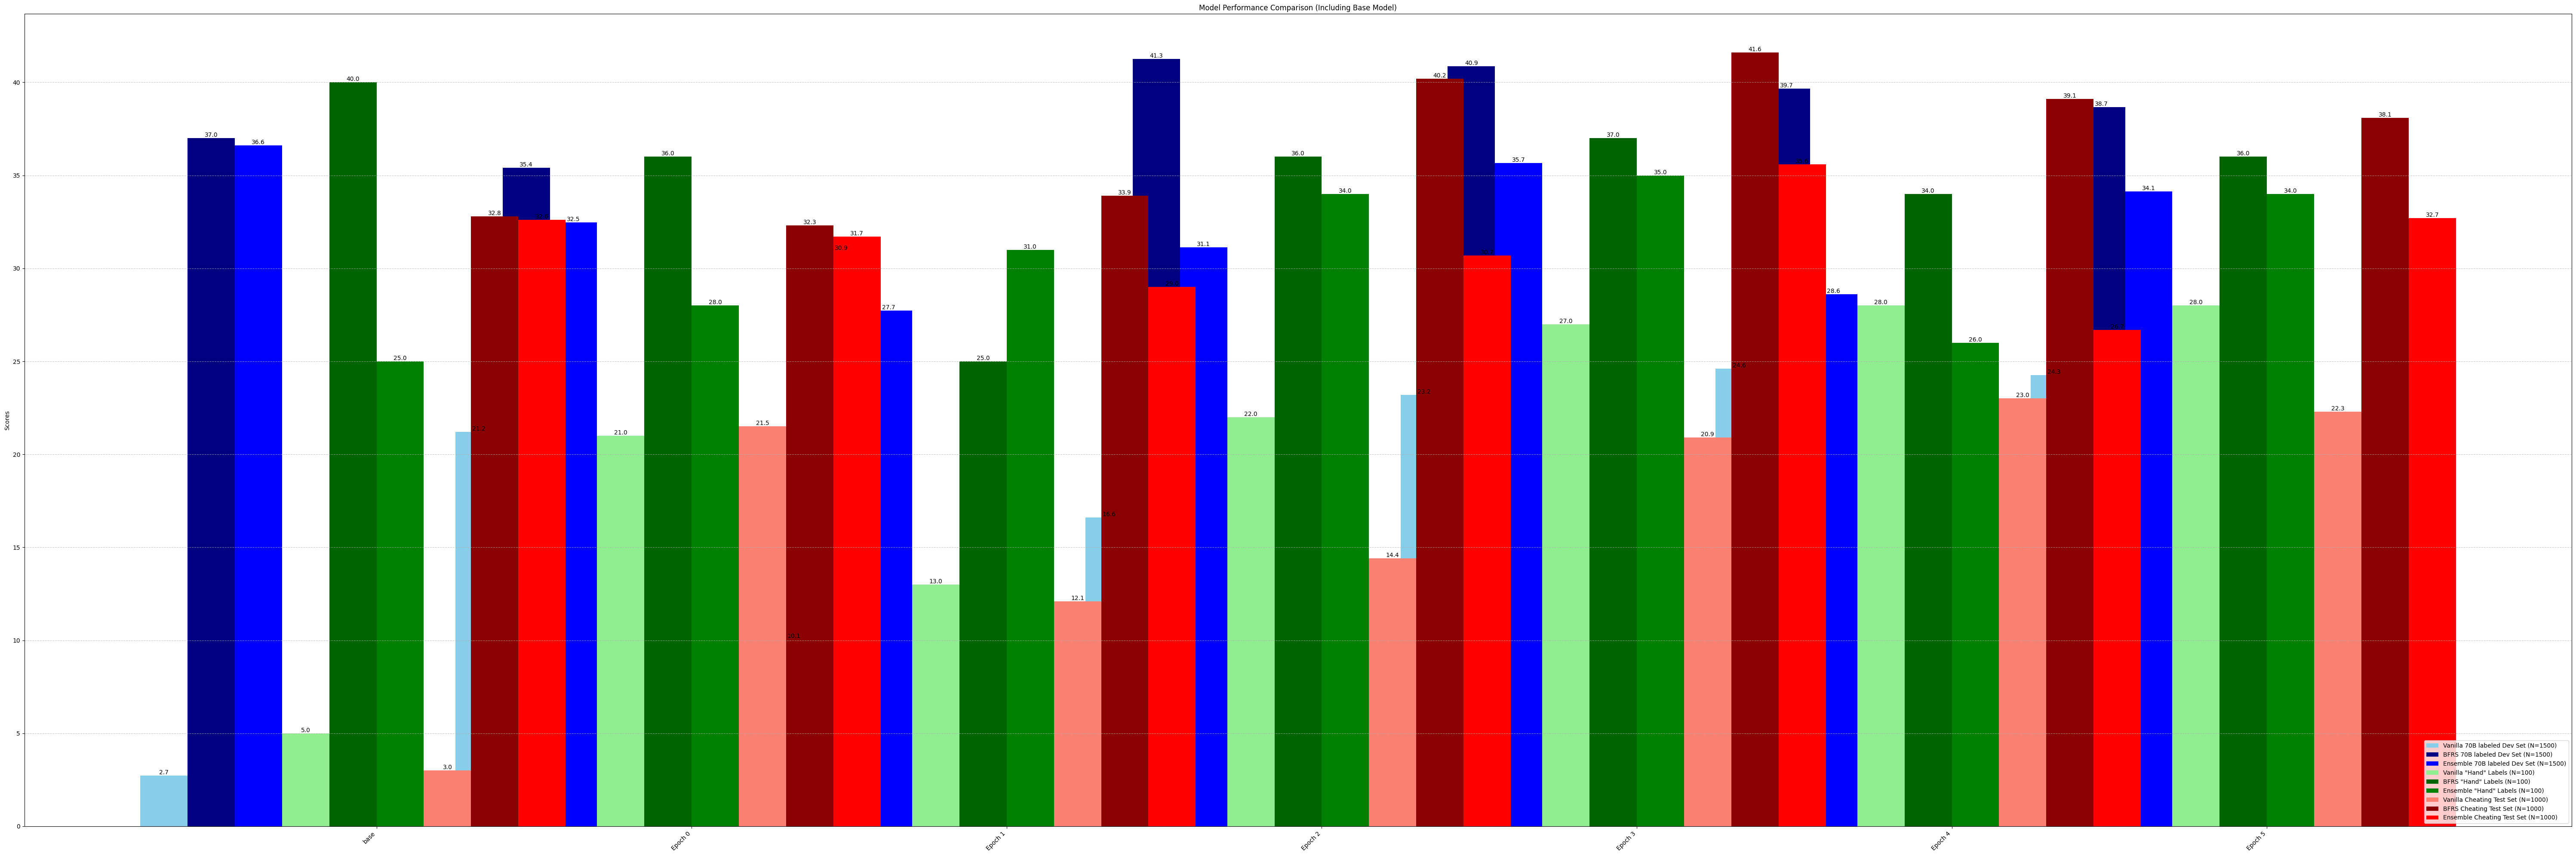

In [54]:
import json
import matplotlib.pyplot as plt
import numpy as np

# Load the ft_results data
# with open('ft_results.json', 'r') as f:
#     ft_results = json.load(f)

# Prepare data for plotting
models = []
vanilla_devset = []
vanilla_true_labels = []
vanilla_testset = []
bfrs_devset = []
bfrs_true_labels = []
bfrs_testset = []
ensemble_devset = []
ensemble_true_labels = []
ensemble_testset = []

for model, results in ft_results.items():
    if model == "base":
        models.append("base")
    else:
        models.append("Epoch " + model.split(':')[1].split('-')[1])  # Extract epoch information
    vanilla_devset.append(results['vanilla']['devset'])
    vanilla_true_labels.append(results['vanilla']['true_labels'])
    vanilla_testset.append(results['vanilla']['testset'])
    bfrs_devset.append(results['bfrs']['devset'])
    bfrs_true_labels.append(results['bfrs']['true_labels'])
    bfrs_testset.append(results['bfrs']['testset'])
    ensemble_devset.append(results['ensemble']['devset'])
    ensemble_true_labels.append(results['ensemble']['true_labels'])
    ensemble_testset.append(results['ensemble']['testset'])

# Sort the data by epoch, keeping "base" at the beginning
sorted_data = sorted(zip(models, vanilla_devset, vanilla_true_labels, vanilla_testset, 
                         bfrs_devset, bfrs_true_labels, bfrs_testset, ensemble_devset, ensemble_true_labels, ensemble_testset),
                     key=lambda x: (x[0] != "base", x[0]))
models, vanilla_devset, vanilla_true_labels, vanilla_testset, bfrs_devset, bfrs_true_labels, bfrs_testset, ensemble_devset, ensemble_true_labels, ensemble_testset = zip(*sorted_data)

# Set up the plot
# Increase figure width
fig, ax = plt.subplots(figsize=(60, 20))

# Adjust bar positions and width
x = np.arange(7)
width = 0.15  # Reduced width to prevent overlap

width_multiplier = 5
widths = np.linspace(-width_multiplier, width_multiplier, 9)
print(widths)
positions = [x + width * (i - 9 / 2) for i in range(9)]

# Define colors
colors = ['skyblue', 'navy', 'blue', 'lightgreen', 'darkgreen', 'green', 'salmon', 'darkred', 'red']

# Data and labels
data = [vanilla_devset, bfrs_devset, ensemble_devset, vanilla_true_labels, 
        bfrs_true_labels, ensemble_true_labels, vanilla_testset, bfrs_testset, ensemble_testset]
labels = ['Vanilla 70B labeled Dev Set (N=1500)', 'BFRS 70B labeled Dev Set (N=1500)', 'Ensemble 70B labeled Dev Set (N=1500)', 'Vanilla "Hand" Labels (N=100)', 'BFRS "Hand" Labels (N=100)', 'Ensemble "Hand" Labels (N=100)',
          'Vanilla Cheating Test Set (N=1000)', 'BFRS Cheating Test Set (N=1000)', 'Ensemble Cheating Test Set (N=1000)']

print(len(data[0]))
# Plot bars
for i, (d, label, color, pos) in enumerate(zip(data, labels, colors, positions)):
    print(d)
    print(label)
    print(color)
    print(pos)
    ax.bar(pos, d, width, label=label, color=color)
    for j, v in enumerate(d):
        ax.text(pos[j], v, f'{v:.1f}', ha='center', va='bottom')


# Customize the plot
ax.set_ylabel('Scores')
ax.set_title('Model Performance Comparison (Including Base Model)')
ax.set_xticks(x)
ax.set_xticklabels(models, rotation=45, ha='right')
ax.legend(loc='lower right')

# Add a grid for better readability
ax.grid(True, axis='y', linestyle='--', alpha=0.7)

# Adjust layout and display
plt.tight_layout()
plt.show()



In [ ]:
# from dspy.teleprompt import MIPROv2
# gpt4o = dspy.LM(model="gpt-4o", **MODEL_PARAMETERS)

# COMPILE_PROGRAM = True

# with dspy.context(lm=current_best):
#     vanilla_program = IntentClassificationModule()
#     if COMPILE_PROGRAM:
#         # eval_kwargs = dict(display_progress=True, display_table=0, num_threads=NUM_THREADS)
#         teleprompter = MIPROv2(prompt_model=gpt4o, task_model=current_best, metric=metric, num_candidates=10, init_temperature=0.9, verbose=True, num_threads=NUM_THREADS, max_errors=1000)
#         compiled_program = teleprompter.compile(vanilla_program, trainset=optimizer_trainset, valset=optimizer_valset, num_trials=30, max_bootstrapped_demos=MAX_BOOTSTRAPPED_DEMOS,max_labeled_demos=MAX_LABELED_DEMOS, requires_permission_to_run=False)
#         compiled_program.save(f"simpleintent_1b_32_ft_mipro_{MAX_BOOTSTRAPPED_DEMOS}_{MAX_LABELED_DEMOS}.json")
#     else:
#         compiled_program = IntentClassificationModule()
#         compiled_program.load(f"simpleintent_1b_32_ft_mipro_{MAX_BOOTSTRAPPED_DEMOS}_{MAX_LABELED_DEMOS}.json")
#     llama_8b_ft_mipro_eval = evaluate_devset(compiled_program)

Lastly, lets give the base 8B model a fair chance by prompt optimizing it.

In [ ]:
# Now we can compare all iterations of this pipeline
print(f"Results for HotPotQA fine-tuning LLaMa 8B with a starting trainset")
print(f"    70B model (vanilla program): {llama_70b_base_eval}")
print(f"    70B model (bfrs program): {llama_70b_bfrs_eval}")
print(f"    8B model (vanilla program): {vanilla_8b_base_eval}")
print(f"    8B model (bfrs program): {llama_8b_bfrs_eval}")
print(f"    8B model (finetuned program): {llama_8b_finetuned_eval}")
print(f"    8B model (finetuned bfrs program): {llama_8b_bfrs_finetuned_eval}")
print(f"    8B model (finetuned mipro program): {llama_8b_ft_mipro_eval}")

TODO: Let's now use the new offline batch inference to evaluate the finetuned model with optimized program on the entire devset

In [ ]:
# TODO: implement once done

In [ ]:
raise NotImplementedError("Stop here")

# Serving

This is the second biggest unknown
I imagine it to be easy, but crazier things have happened

I need to keep a reference or link to the LLM forge job inside the LM.finetune method

how do I get the ray llm image!

We'll start by running the rayllm CLI command below to start the workflow to generate the service yaml configuration:
```bash
mkdir /home/ray/default/deploy/services
cd /home/ray/default/deploy/services
rayllm gen-config 
```

<img src="assets/cli.png" width=500 alt="todo! get this inage of what I need to serve">


## Batch offline inference
- Compare running inference using 
    - Ray Data 
    - multithreading on local VLLM thru HTTP
    - Multithreading to Ray Serve instance thru HTTP
- Dev time estimate: 7 days

<b style="background-color: yellow;">&nbsp;🛑 IMPORTANT&nbsp;</b>: Please `Terminate` your service from the Service page to avoid depleting your free trial credits.

In [ ]:
# Clean up
!python src/clear_cell_nums.py
!find . | grep -E ".ipynb_checkpoints" | xargs rm -rf
!find . | grep -E "(__pycache__|\.pyc|\.pyo)" | xargs rm -rf
!rm -rf __pycache__ data .HF_TOKEN deploy/services

# MARK: Synthetic 70B Labels

In [1]:
# Lets do some data analysis and cleaning
# First we will convert the data to a pandas dataframe
import pandas as pd

# TODO: Move
# For realism of this scenario, we are going to delete all our labels except for our test set(which is cheating and we wouldn't have in production) and our 100 true labeled examples

def delete_labels(dataset):
    for example in dataset:
        if "label" in example:
            del example["label"]
    return dataset

trainset_to_label = delete_labels(trainset_to_label)
# Convert collected_data to a pandas DataFrame
data_dict = {
    'example': [item[0]["text"] for item in collected_data],
    'label': [item[1]["label"] for item in collected_data],
    'reasoning': [item[1]["reasoning"] for item in collected_data]
}
df = pd.DataFrame(data_dict)

# Save the DataFrame to a CSV file
df.to_csv("collected_data.csv", index=False)

# Load the CSV file into a pandas DataFrame
df = pd.read_csv("collected_data.csv")

# Display the DataFrame
print(df.head())

# Lets see how many labels are invalid (not in the top 25 most common labels)
df['label'].value_counts()
df_cleaned = df[df['label'].isin(labels_in_use)]
print("Length of cleaned dataframe:", len(df_cleaned))

# Save the cleaned DataFrame to a CSV file
df_cleaned.to_csv("collected_data_cleaned.csv", index=False)

dspy.settings.configure(experimental=True, lm=llama_70b)

from dspy.teleprompt.finetune_teleprompter import bootstrap_data,bootstrap_data_for_round, convert_to_module_level_message_data    

vanilla_program = IntentClassificationModule()
data = bootstrap_data(vanilla_program, trainset_to_label, metric=fake_metric, num_threads=NUM_THREADS, max_errors=10000)
data_example_ind_map = {data_dict["example_ind"]: idx for idx, data_dict in enumerate(data)}
# Convert the data to prompt completion format
dataset = convert_to_module_level_message_data(data, program=vanilla_program, exclude_demos=True)

training_data = data.copy()
for idx, data_dict in enumerate(training_data):
    fields_to_keep = ["example", "example_ind", "prediction"]
    training_data[idx] = {k: v for k, v in data_dict.items() if k in fields_to_keep}
    training_data[idx].update({"finetunable_data": dataset[idx]})

print(training_data[0])

filtered_training_data = [x for x in training_data if x["prediction"].label in labels_in_use]
TRAIN_SIZE_ADJUSTED = min(2000, len(filtered_training_data) - DEV_SIZE - PROMPT_OPT_TRAIN_SIZE - PROMPT_OPT_DEV_SIZE)
print(len(filtered_training_data), TRAIN_SIZE_ADJUSTED)

# save the training data for future use

if True:
    filtered_training_data = ujson.load(open("training_data.json", "r"))
    TRAIN_SIZE_ADJUSTED = min(2000, len(filtered_training_data) - DEV_SIZE - PROMPT_OPT_TRAIN_SIZE - PROMPT_OPT_DEV_SIZE)
else:
    with open("training_data.json", "w") as f:
        ujson.dump(filtered_training_data, f)

ft_trainset = filtered_training_data[:TRAIN_SIZE_ADJUSTED]
ft_devset = filtered_training_data[TRAIN_SIZE_ADJUSTED:TRAIN_SIZE_ADJUSTED+DEV_SIZE]
optimizer_trainset = filtered_training_data[TRAIN_SIZE_ADJUSTED+DEV_SIZE:TRAIN_SIZE_ADJUSTED+DEV_SIZE+PROMPT_OPT_TRAIN_SIZE]
optimizer_valset = filtered_training_data[TRAIN_SIZE_ADJUSTED+DEV_SIZE+PROMPT_OPT_TRAIN_SIZE:TRAIN_SIZE_ADJUSTED+DEV_SIZE+PROMPT_OPT_TRAIN_SIZE+PROMPT_OPT_DEV_SIZE]

def convert_example_predictions_to_example(dataset):
    data = []
    for item in dataset:
        data.append(dspy.Example(text=item["example"]["text"], label=item["prediction"]["label"], reasoning=item["prediction"]["reasoning"]).with_inputs("text"))
    return data

ft_devset_examples = convert_example_predictions_to_example(ft_devset)
optimizer_trainset = convert_example_predictions_to_example(optimizer_trainset)
optimizer_valset = convert_example_predictions_to_example(optimizer_valset)

evaluate_devset = Evaluate(devset=ft_devset_examples, metric=metric, num_threads=NUM_THREADS, display_progress=True, max_errors=10000)

# Note: Maybe dont use devset here
dataset_filenames = {f"trainset_data_banking_{TRAIN_SIZE}.jsonl": ft_trainset, f"trainset_val_data_banking_{DEV_SIZE}.jsonl": ft_devset}

for filename, data in dataset_filenames.items():
    # we first need to convert the data to be only the messages and to be in proper messages format
    messages_format = [{"messages": data_dict["finetunable_data"]} for data_dict in data]
    # print(messages_format[0])

    write_jsonl(filename, messages_format)

NameError: name 'trainset_to_label' is not defined